# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import pickle

In [2]:
df = pd.read_csv("LandingGear_Balanced_Dataset.csv")
df.head()

,RunID,Max_Deflection,Max_Velocity,Settling_Time,Mass,K_Stiffness,B_Damping,Fault_Code,RUL
0,1,0.3,0.592124,0.330689,4653.503425,156086.879056,3850.794727,0,97.220855
1,2,0.3,0.619103,0.345473,3187.526077,143963.106075,3911.399288,0,94.485389
2,3,0.3,0.589439,0.330372,4882.371127,156973.328028,3863.045233,0,99.362603
3,4,0.3,0.594537,0.348994,1567.545355,149780.634731,4120.112188,0,99.357504
4,5,0.3,0.579618,0.341858,4837.969706,156236.032878,4116.882932,0,91.326419


# Data Exploration

In [3]:
df['Fault_Code'].value_counts()

Fault_Code
1    500
2    500
0    300
3    200
Name: count, dtype: int64

In [4]:
df.describe()

,RunID,Max_Deflection,Max_Velocity,Settling_Time,Mass,K_Stiffness,B_Damping,Fault_Code,RUL
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,0.300018,0.673895,0.393192,3013.640972,136978.482654,3431.891548,1.400000,62.102630
std,433.157015,0.000156,0.071852,0.069448,1156.133997,19948.112877,848.728578,0.952508,29.634244
min,1.000000,0.300000,0.574557,0.317767,1001.365849,80000.000000,1000.000000,0.000000,0.000000
25%,375.750000,0.300000,0.614667,0.338473,2020.267452,131075.000000,3217.250000,1.000000,37.400000
50%,750.500000,0.300000,0.657142,0.365980,3062.448216,147287.835278,3891.532860,1.000000,72.062500
75%,1125.250000,0.300000,0.714344,0.444915,4010.413004,150000.000000,4000.000000,2.000000,87.653833
max,1500.000000,0.301976,0.914319,0.653655,4997.911435,157492.374301,4199.632158,3.000000,99.930846


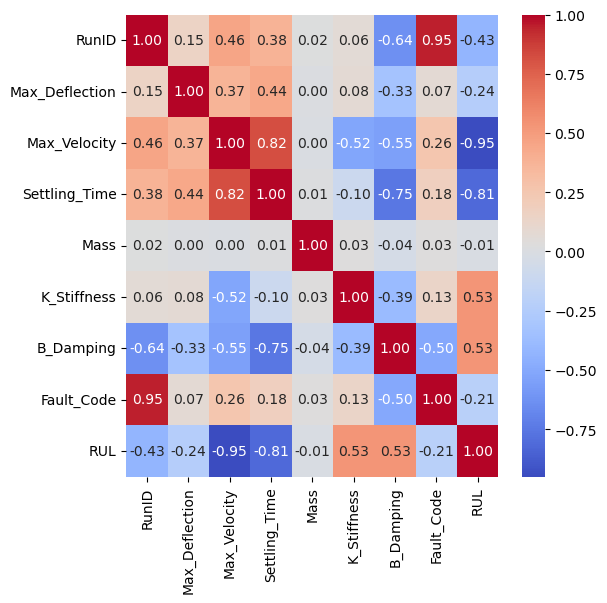

In [5]:
corr = df.corr()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax = sns.heatmap(corr, annot=True, cmap = "coolwarm", fmt=".2f")
plt.show()

In [6]:
df.columns

Index(['RunID', 'Max_Deflection', 'Max_Velocity', 'Settling_Time', 'Mass',
       'K_Stiffness', 'B_Damping', 'Fault_Code', 'RUL'],
      dtype='object')

In [7]:
df["fault"] = df["Fault_Code"].map({0:"Normal Operation", 
                                    1:"Nitrogen Gas Leak (Reduced Stiffness)", 
                                    2:"Worn Seal (Reduced Damping)", 
                                    3:"Early Structural Degradation"})

# Train-Test Split

In [10]:
y = df["Fault_Code"]
x = df.drop(columns=["Fault_Code", "fault"])

In [11]:
fault_mapping = (
    df[["Fault_Code", "fault"]]
    .drop_duplicates()
    .set_index("Fault_Code")["fault"]
    .to_dict()
)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

# Model

In [18]:
model = LogisticRegression()
scaler = StandardScaler()

In [19]:
x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size = 0.25)  #val set

In [20]:
x_train_scaled = scaler.fit_transform(x_t)
x_val_scaled = scaler.transform(x_v)

In [21]:
model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

In [22]:
model.fit(x_train_scaled, y_t)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [23]:
y_pred_val = model.predict(x_val_scaled)

In [24]:
r2_score(y_v,y_pred_val)

0.9678435508929971

In [25]:
np.mean(cross_val_score(model, x_train_scaled, y_t, scoring="r2",cv=10))

0.9766482938959491

# Pipeline

In [26]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        n_jobs=-1
    ))
])

In [27]:
pipe.fit(x_train, y_train)  #fitting to the training data

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=2000, n_jobs=-1))])

In [28]:
y_pred_train = pipe.predict(x_train)

In [29]:
scores = cross_val_score(pipe, x_train, y_train, cv=5)
scores

array([0.97333333, 0.98222222, 0.98666667, 0.97333333, 0.96444444])

In [30]:
y_pred_test = pipe.predict(x_test)

In [31]:
scores = cross_val_score(pipe, x_test, y_test, cv=5)
scores

array([0.98666667, 0.97333333, 0.98666667, 0.97333333, 0.96      ])

In [32]:
test_set_accuracy = np.mean(y_pred_test == y_test)
test_set_accuracy

0.9866666666666667

# Package and Save

In [34]:
model_bundle = {
    "model": pipe,
    "feature_names": list(x.columns),
    "fault_mapping": fault_mapping
}

In [35]:
with open("fault_prediction_model.pkl", "wb") as f:
    pickle.dump(model_bundle, f)